In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

from framework import ModelGraph

In [2]:
# 1. initialize
#-------------#
# Size N of population:
N = 1000
# Parameters
R0 = 3                              #   reproduction number
gamma = np.array([0.4,0.3,0.1])     #   age dependent recovery constant

graph_dict = {
    "age_groups": 3,
    "nodes": {
        "S": {"init": [990,1000,1000]},
        "I": {"init": [10,1,1]},
        "R": {"init": [0,0,0]}
    },
    # key pair: (state_from, state_to)
    "edges": {
        ("S", "I"): {
            "weight": R0 * gamma / N
        },
        ("I", "R"): {
            "weight": gamma
        }
    },
    # key triplet: (infectious, susceptible, infected)
    "transmission": {
        ("I", "S", "I"):
            {"param": 1.0}
    },
    "contact_matrix": 
        [[1,1,1],
         [1,1,1],
         [1,1,1]]
}
model = ModelGraph(graph_dict=graph_dict)

# t = 0
time_series = [0]     #[0,t1,t2,t3,...]

# variables derived from model
# initial values
init_vals = np.array(list(model.initial_values.values()))

# state variables
state_var = np.array([init_vals])

# last state
last_state = init_vals

# compartmental states
s, i, r = init_vals

# number of age groups
n_ag = model.n_ag

# number of compartments
n_comp = len(model.nodes)

# compartment indexer
c_idx = model.c_idx

In [3]:
# Halting condition: (i = 0) <- used in while cycle
# cntr = 0
while np.sum(i) > 0 :

    # 2. Calculate propensity matrix:
    #----------------------------------#
    # transition are defined as: state_mtx[a] * param_mtx[a], e.g. gamma[a] * I[a] for age 'a'
    state_mtx = np.zeros((n_ag, n_comp, n_comp))
    for n_from, n_to in model.edges:
        # get indices for nodes 'from' and 'to'
        i_from, i_to = c_idx[n_from], c_idx[n_to]
        # fill 'from' compartment from last state to the proper element array
        state_mtx[:, i_from, i_to] = last_state[i_from]
    
    # transmission are defined as: state_mtx[a] * param_mtx[a] * transmission_corr[a],
    # e.g. beta[a] * s[a] * (i1 + i2 + ...).dot(contact_mtx[:, a]) 
    # for age 'a' and infectious classes i1, i2, ... 
    transmission_corr = np.ones((n_ag, n_comp, n_comp))
    for n_from, n_to in model.transmissions.keys():
        # get indices for nodes 'from' and 'to'
        i_from, i_to = c_idx[n_from], c_idx[n_to]
        
        # for selected (from, to) pair add up corresponding last infectious states w.r.t weights
        inf_states = np.zeros((1, n_ag))
        for inf, inf_w in model.transmissions[(n_from, n_to)].items():
            # get indices for infectious node
            i_inf = c_idx[inf]
            inf_states += inf_w * last_state[i_inf]

        transmission_corr[:, i_from, i_to] = inf_states.dot(model.contact_matrix).flatten()
    
    P_mtx = state_mtx * transmission_corr * np.array(model.param_mtx)

    a = np.sum(P_mtx)

    # 3. Decide when will the next reaction occur:
    #--------------------------------------------#
    tau = random.expovariate(a) # by using the implemented pseudo random generator

    # 4. Decide which reaction occurs:
    #--------------------------------#
    r2 = random.uniform(0,1)

    # for mu in range(len(propensities)):
    #   p = 0
    #   p += propensities[mu]
    #   if r2 * a < p: break
    index_arrays = np.where(np.cumsum(P_mtx).reshape(P_mtx.shape) > r2 * a)
    age, c_from, c_to = index_arrays[0][0], index_arrays[1][0], index_arrays[2][0]

    # 5. Update time and state variables:
    #-----------------------------------#
    time_series.append(time_series[-1] + tau)
    changed = np.copy(state_var[-1])
    changed[c_from, age] -= 1
    changed[c_to, age] += 1
    # if cntr < 100:
    #   print(changed)
    #   cntr += 1
    state_var = np.append(state_var, [changed], axis=0)
    last_state = changed
    
    s = state_var[-1][0]
    i = state_var[-1][1]
    r = state_var[-1][2]

    # 6. Halting conditions are used in while cycle
    #---------------------------------------------#

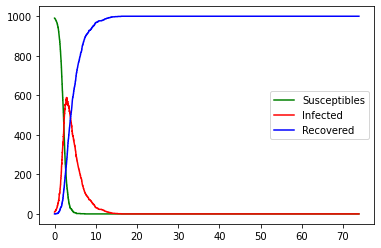

In [4]:
# Code to show graph

fig, ax = plt.subplots()
ax.plot(time_series, state_var[:, 0, 0], "g")
ax.plot(time_series, state_var[:, 1, 0], "r")
ax.plot(time_series, state_var[:, 2, 0], "b")
ax.legend(["Susceptibles", "Infected", "Recovered"], loc="best") 
plt.show()